# import Libray ，取得資料集

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import cosine, correlation


LINK = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'

In [ ]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -n ml-100k.zip

--2022-12-21 05:08:23--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  16.5MB/s    in 0.3s    

2022-12-21 05:08:24 (16.5 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

#Loading MovieLens dataset

In [ ]:
#Load u.data 
rating_header = ["user_id","item_id","rating","timestamp"]
rating = pd.read_csv("ml-100k/u.data",sep="\t",header = None , names=rating_header)
rating.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
#Load u.user
user_header = ["user_id", "age", "gender", "occupation", "zip_code"]
users = pd.read_csv("ml-100k/u.user", sep = '|', header = None, names=user_header)
users.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [ ]:
# Load u.item
movie_header = ["item_id", "title", "release_date", "video_release_date", "IMDb_URL",
         "unknown", "Action", "Adventure", "Animation","Children's", "Comedy", "Crime",
         "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", 
         "Romance", "Sci-Fi", "Thriller", "War", "Western"]
movies = pd.read_csv("ml-100k/u.item", sep = '|', header = None, encoding = 'latin1', names = movie_header)
movies.head()

,item_id,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# 基本資料分析


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc839574340>]],
      dtype=object)

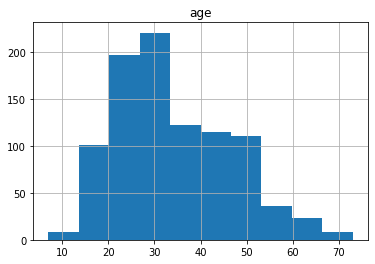

In [ ]:
users.hist(column='age')

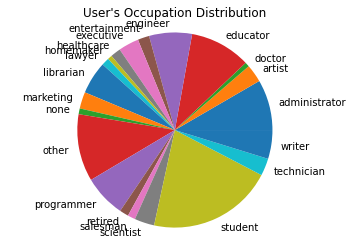

In [ ]:
occupation_count = users[["user_id", "occupation"]].groupby("occupation", as_index=False).size()  # count the numbers
plt.pie(occupation_count["size"], labels=occupation_count["occupation"])
plt.title("User's Occupation Distribution")
plt.axis("equal")
plt.show()

計算各個rating的個數，以及取對數並畫圖

下列程式碼可以看得出來有 18 筆資料 ，已經映射的電影標題還有18個額外的電影ID,並且在用戶項目數據集中將相同的重複電影ID分配給用戶。

In [ ]:
movie_dataset = movies[['item_id','title']]
len(movies.groupby(by=movie_header[1:])),len(movies)

(1664, 1682)

合併item base CF 與 分析 rating 需要的 datasets 

In [ ]:
merge_dataset = pd.merge(rating,movie_dataset,how='inner',on='item_id')
merge_dataset.head()
#依照user_id分群，並且將上個block提到的一個用戶對同部電影有多個評分取平均
refined_dataset = merge_dataset.groupby(by=['user_id','title'],as_index=False).agg({"rating":"mean"})
refined_dataset.head()

,user_id,title,rating
0,1,101 Dalmatians (1996),2.0
1,1,12 Angry Men (1957),5.0
2,1,"20,000 Leagues Under the Sea (1954)",3.0
3,1,2001: A Space Odyssey (1968),4.0
4,1,"Abyss, The (1989)",3.0


In [ ]:
num_users = len(refined_dataset['user_id'].value_counts())
num_items = len(refined_dataset['title'].value_counts())
print("Unique users in dataset: {}".format(num_users))
print("Unique movies in dataset: {}".format(num_items))

Unique users in dataset: 943
Unique movies in dataset: 1664


In [ ]:
#依照rating做counting
rating_count_df = pd.DataFrame(refined_dataset.groupby(['rating']).size() , columns=['count'])
rating_count_df

,count
rating,
1.0,6083
1.5,3
2.0,11334
2.5,6
3.0,27060
3.5,19
4.0,34042
4.5,16
5.0,21130


In [ ]:
#發現 x.5 等分數相比於其他差距過大 ，因此下個block 將取log
#並且將沒有用戶沒有打分的資料rating預設為0
total_count = num_items * num_users
zero_count = total_count-refined_dataset.shape[0]
zero_count

1469459

In [ ]:
rating_count_df = rating_count_df.append(
    pd.DataFrame({'count':zero_count},index=[0.0]),
    verify_integrity=True
).sort_index()
rating_count_df['log'] = np.log(rating_count_df['count'])
rating_count_df = rating_count_df.reset_index().rename(columns={'index':'rating score'})
rating_count_df

,rating score,count,log
0,0.0,1469459,14.200405
1,1.0,6083,8.713253
2,1.5,3,1.098612
3,2.0,11334,9.335562
4,2.5,6,1.791759
5,3.0,27060,10.205812
6,3.5,19,2.944439
7,4.0,34042,10.435350
8,4.5,16,2.772589
9,5.0,21130,9.958449


Text(0, 0.5, 'number of ratings')

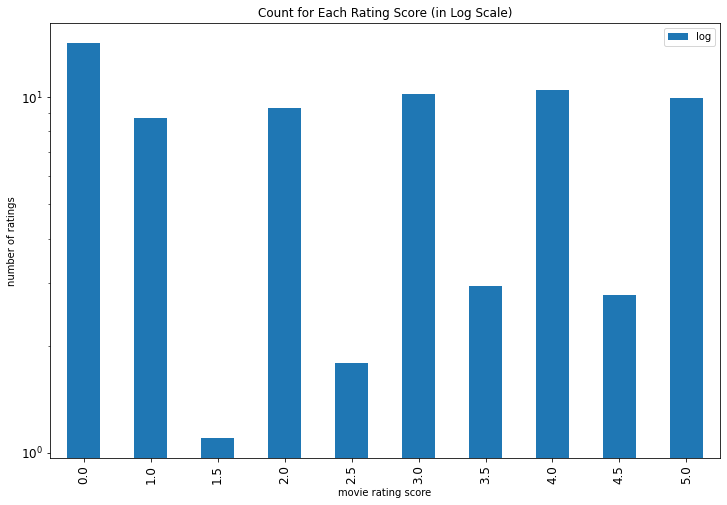

In [ ]:
ax = rating_count_df.plot('rating score', 'log', 'bar', figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

#畫出電影被評分頻率

Text(0, 0.5, 'number of ratings')

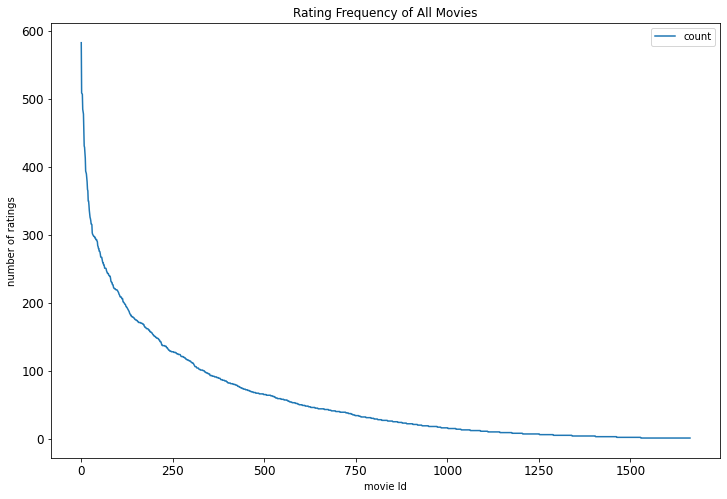

In [ ]:
movies_count_df = pd.DataFrame(refined_dataset.groupby('title').size(), columns=['count'])
movies_count_df
ax = movies_count_df \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

雖然movieLens的資料集很小，但由上圖還是可以大概看出 [Long Tail Effect] 。即只有一小部分的物品頻繁評級。這些稱為流行項目。絕大多數的物品很少被評級。

# 用SKlern訓練 KNN 模型以建構 item-based CF RS
## 1. Reshape the dataframe

先把電影為行，用戶爲列。並且將用戶沒有評分的電影以０填充。（以計算兩個向量的距離）

最後將處理好的稀疏矩陣輸入給KNN模型

In [ ]:
# pivot and create movie-user matrix
user_to_movie_df = refined_dataset.pivot(
    index='user_id',
    columns='title',
    values='rating').fillna(0)
user_to_movie_df.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,2.0,5.0,0.0,0.0,3.0,4.0,0.0,0.0,...,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0


In [ ]:
#transform matrix to scipy sparse matrix
user_to_movie_sparse_df = csr_matrix(user_to_movie_df.values)
user_to_movie_df.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,2.0,5.0,0.0,0.0,3.0,4.0,0.0,0.0,...,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0


In [ ]:
#Fitting K-Nearest Neighbors model to the scipy sparse matrix
knn_model = NearestNeighbors(metric='cosine' , algorithm="brute")
knn_model.fit(user_to_movie_sparse_df)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
# 定義function 來找與input user 前n個相似的users
def get_similar_users(user , n=5):
  
  knn_input = np.asarray([user_to_movie_df.values[user-1]])
  distances , indices = knn_model.kneighbors(knn_input,n_neighbors=n+1)

  print("Top",n,"users who are very similar to the User ", user , 'are:')
  print()
  for i in range(1,len(distances[0])):
    print(i,". User:", indices[0][i]+1 , "separated by distance of", distances[0][i] )
  return indices.flatten()[1:] + 1 , distances.flatten()[1:]

In [ ]:
# 印出特定用戶最喜歡的前10部電影 。 並找出前五名最相似的用戶
from pprint import pprint
user_id = 365
# print("movies seen by the User:")
# pprint(list(refined_dataset[refined_dataset['user_id'] == user_id]['title'])[:10])
similar_user_list, distance_list = get_similar_users(user_id,5)

Top 5 users who are very similar to the User  365 are:

1 . User: 63 separated by distance of 0.5519992860764589
2 . User: 486 separated by distance of 0.5545108148019076
3 . User: 624 separated by distance of 0.5723575373849275
4 . User: 717 separated by distance of 0.5807613063498749
5 . User: 74 separated by distance of 0.5908944620374638


由KNN建構的模型我們可以得到前幾名類似的用戶
並將他們最喜歡的電影推薦給指定的用戶

然而，如果根據與輸入用戶的距離來定義每個用戶的評分權重，則建議會更準確。

In [ ]:
print(similar_user_list)
print(distance_list)
weightage_list = distance_list/np.sum(distance_list)
print(weightage_list)
# 前n名相似使用者之所有評分
mov_rtngs_sim_users = user_to_movie_df.values[similar_user_list]
mov_rtngs_sim_users

[ 63 486 624 717  74]
[0.55199929 0.55451081 0.57235754 0.58076131 0.59089446]
[0.1936484  0.19452947 0.20079033 0.20373848 0.20729332]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 2., ..., 0., 0., 0.]])

In [ ]:
# 把所有電影擷取出來以創建推薦名單
movies_list = user_to_movie_df.columns
movies_list #所有的電影名稱[]

print("Weightage list shape:", len(weightage_list))
print("mov_rtngs_sim_users shape:", mov_rtngs_sim_users.shape)
print("Number of movies:", len(movies_list))

Weightage list shape: 5
mov_rtngs_sim_users shape: (5, 1664)
Number of movies: 1664


In [ ]:
weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(movies_list))
weightage_list.shape             # ^插入新維度

(5, 1664)

In [ ]:
new_rating_matrix = weightage_list*mov_rtngs_sim_users
mean_rating_list = new_rating_matrix.sum(axis =0)
mean_rating_list

array([0.        , 0.        , 0.41458664, ..., 0.        , 0.        ,
       0.        ])

In [ ]:
from pprint import pprint
def recommend_movies(n):
  n = min(len(mean_rating_list),n)
  # print(np.argsort(mean_rating_list)[::-1][:n])
  pprint(list(movies_list[np.argsort(mean_rating_list)[::-1][:n]]))

In [ ]:
print("Movies recommended based on similar users are: ")
recommend_movies(10)

Movies recommended based on similar users are: 
['Star Trek: First Contact (1996)',
 'Mission: Impossible (1996)',
 'Independence Day (ID4) (1996)',
 'Fargo (1996)',
 'Air Force One (1997)',
 'Heat (1995)',
 'Broken Arrow (1996)',
 'Truth About Cats & Dogs, The (1996)',
 'Eraser (1996)',
 'Fugitive, The (1993)']


## 1.可能推薦input user 已經看過的電影
## 2.可能推薦沒被任何類似用戶看過的電影

In [ ]:
def filtered_movie_recommendations(n):
  #透過陣列的排序篩選可以篩選出保證相似用戶看過的電影
  first_zero_index = np.where(mean_rating_list == 0)[0][-1]
  sortd_index = np.argsort(mean_rating_list)[::-1]
  sortd_index = sortd_index[:list(sortd_index).index(first_zero_index)]
  n = min(len(sortd_index),n)
  movies_watched = list(refined_dataset[refined_dataset['user_id'] == user_id]['title'])
  filtered_movie_list = list(movies_list[sortd_index])
  count = 0
  final_movie_list = []
  for i in filtered_movie_list:
    if i not in movies_watched:
      count+=1
      final_movie_list.append(i)
    if count == n:
      break
  if count == 0:
    print("There are no movies left which are not seen by the input users and seen by similar users. May be increasing the number of similar users who are to be considered may give a chance of suggesting an unseen good movie.")
  else:
    pprint(final_movie_list)

In [ ]:
filtered_movie_recommendations(10)

['Mission: Impossible (1996)',
 'Independence Day (ID4) (1996)',
 'Air Force One (1997)',
 'Heat (1995)',
 'Broken Arrow (1996)',
 'Truth About Cats & Dogs, The (1996)',
 'Eraser (1996)',
 'Fugitive, The (1993)',
 'Pulp Fiction (1994)',
 'Terminator 2: Judgment Day (1991)']


In [ ]:
from pprint import pprint

def recommender_system(user_id, n_similar_users, n_movies): #, user_to_movie_df, knn_model):
  
  print("Movie seen by the User:")
  # pprint(list(refined_dataset[refined_dataset['user_id'] == user_id]['title']))
  print("")

  # def get_similar_users(user, user_to_movie_df, knn_model, n = 5):
  def get_similar_users(user, n = 5):
    
    knn_input = np.asarray([user_to_movie_df.values[user-1]])
    
    distances, indices = knn_model.kneighbors(knn_input, n_neighbors=n+1)
    
    print("Top",n,"users who are very much similar to the User-",user, "are: ")
    print(" ")

    for i in range(1,len(distances[0])):
      print(i,". User:", indices[0][i]+1, "separated by distance of",distances[0][i])
    print("")
    return indices.flatten()[1:] + 1, distances.flatten()[1:]


  def filtered_movie_recommendations(n = 10):
  
    first_zero_index = np.where(mean_rating_list == 0)[0][-1]
    sortd_index = np.argsort(mean_rating_list)[::-1]
    sortd_index = sortd_index[:list(sortd_index).index(first_zero_index)]
    n = min(len(sortd_index),n)
    movies_watched = list(refined_dataset[refined_dataset['user_id'] == user_id]['title'])
    filtered_movie_list = list(movies_list[sortd_index])
    count = 0
    final_movie_list = []
    for i in filtered_movie_list:
      if i not in movies_watched:
        count+=1
        final_movie_list.append(i)
      if count == n:
        break
    if count == 0:
      print("There are no movies left which are not seen by the input users and seen by similar users. May be increasing the number of similar users who are to be considered may give a chance of suggesting an unseen good movie.")
    else:
      pprint(final_movie_list)

  similar_user_list, distance_list = get_similar_users(user_id,n_similar_users)
  weightage_list = distance_list/np.sum(distance_list)
  mov_rtngs_sim_users = user_to_movie_df.values[similar_user_list]
  movies_list = user_to_movie_df.columns
  weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(movies_list))
  new_rating_matrix = weightage_list*mov_rtngs_sim_users
  mean_rating_list = new_rating_matrix.sum(axis =0)
  print("")
  print("Movies recommended based on similar users are: ")
  print("")
  filtered_movie_recommendations(n_movies)

In [ ]:
import random
#print("Enter user id")
user_id= 771#random.randint(1,943)
print("number of similar users to be considered")
sim_users = 5
print("Enter number of movies to be recommended:")
n_movies = 10
recommender_system(user_id,sim_users,n_movies)

number of similar users to be considered
Enter number of movies to be recommended:
Movie seen by the User:

Top 5 users who are very much similar to the User- 771 are: 
 
1 . User: 654 separated by distance of 0.5904589977738943
2 . User: 43 separated by distance of 0.603799998757945
3 . User: 661 separated by distance of 0.6377086226263661
4 . User: 838 separated by distance of 0.6438455212932266
5 . User: 514 separated by distance of 0.646843536482131


Movies recommended based on similar users are: 

['Fargo (1996)',
 'Secrets & Lies (1996)',
 'Welcome to the Dollhouse (1995)',
 "Devil's Advocate, The (1997)",
 'Primal Fear (1996)',
 'Celluloid Closet, The (1995)',
 'Leaving Las Vegas (1995)',
 'Godfather, The (1972)',
 'Men in Black (1997)',
 'Independence Day (ID4) (1996)']


---
#以pytorch Deep Lerning 預測使用者的 rating
(Auto Encoder)


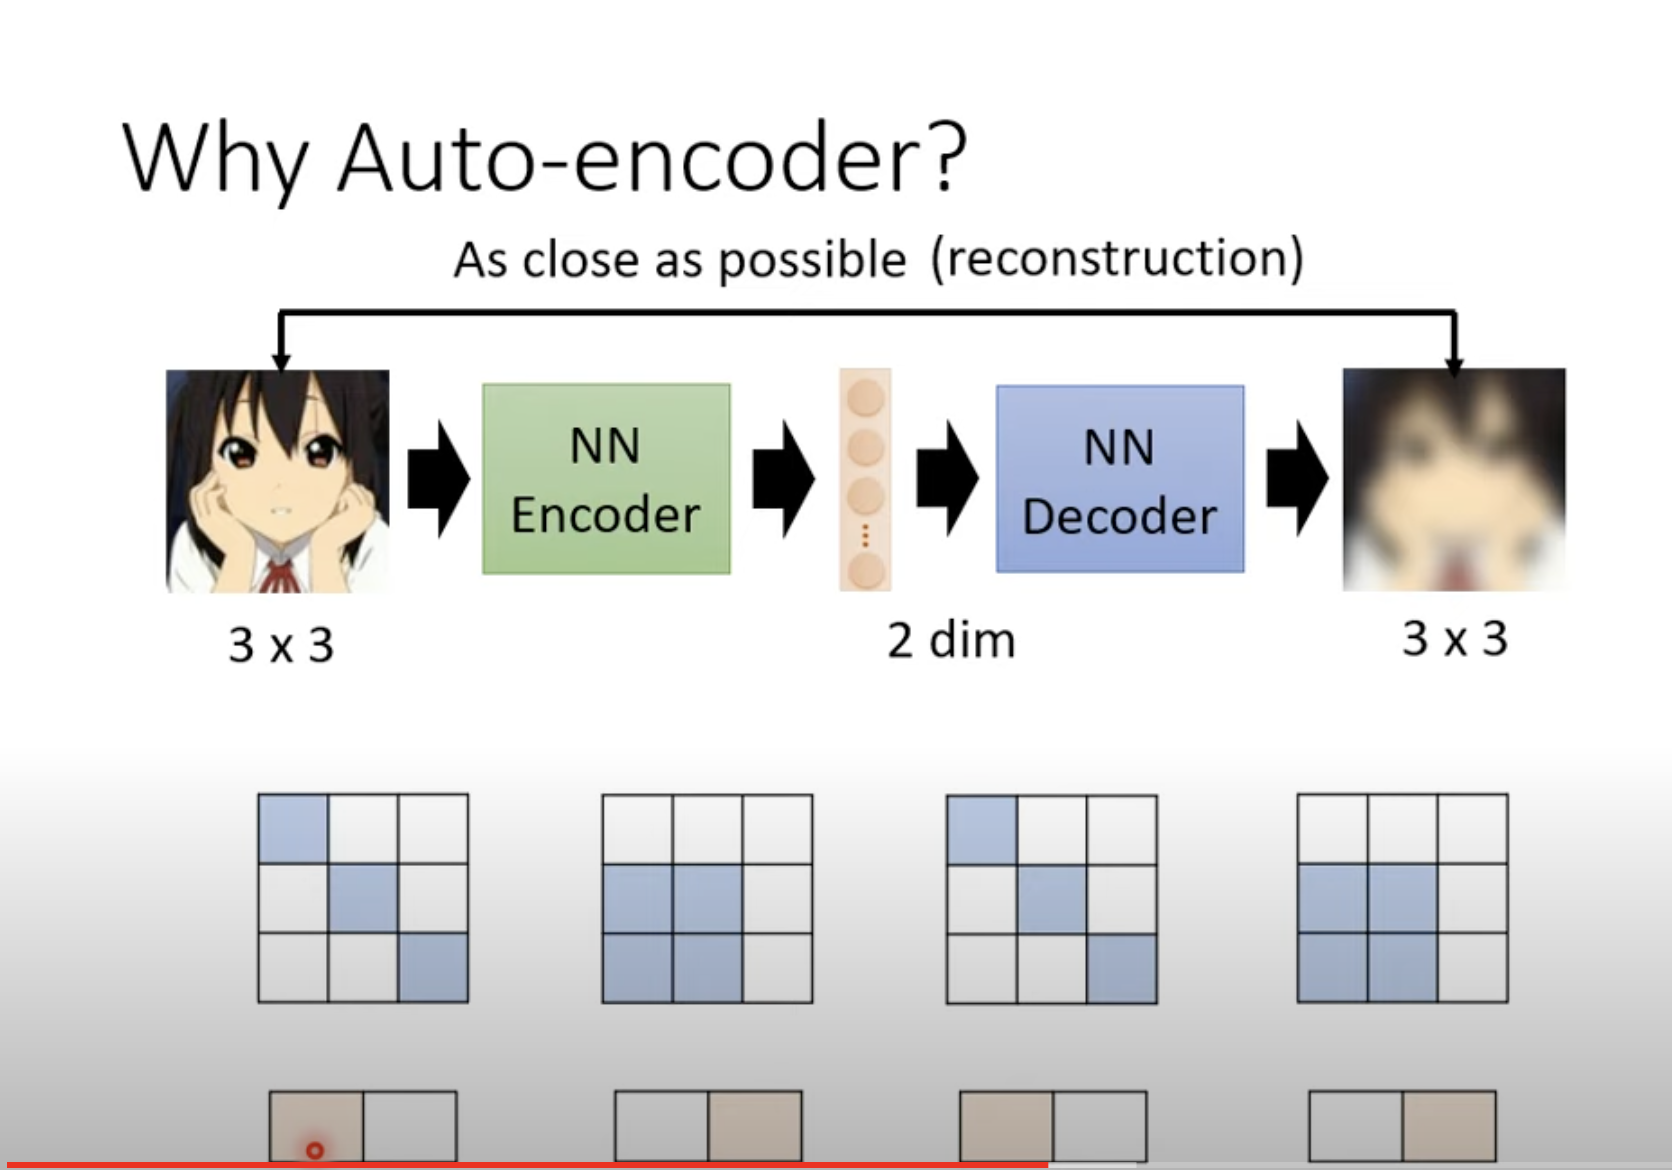

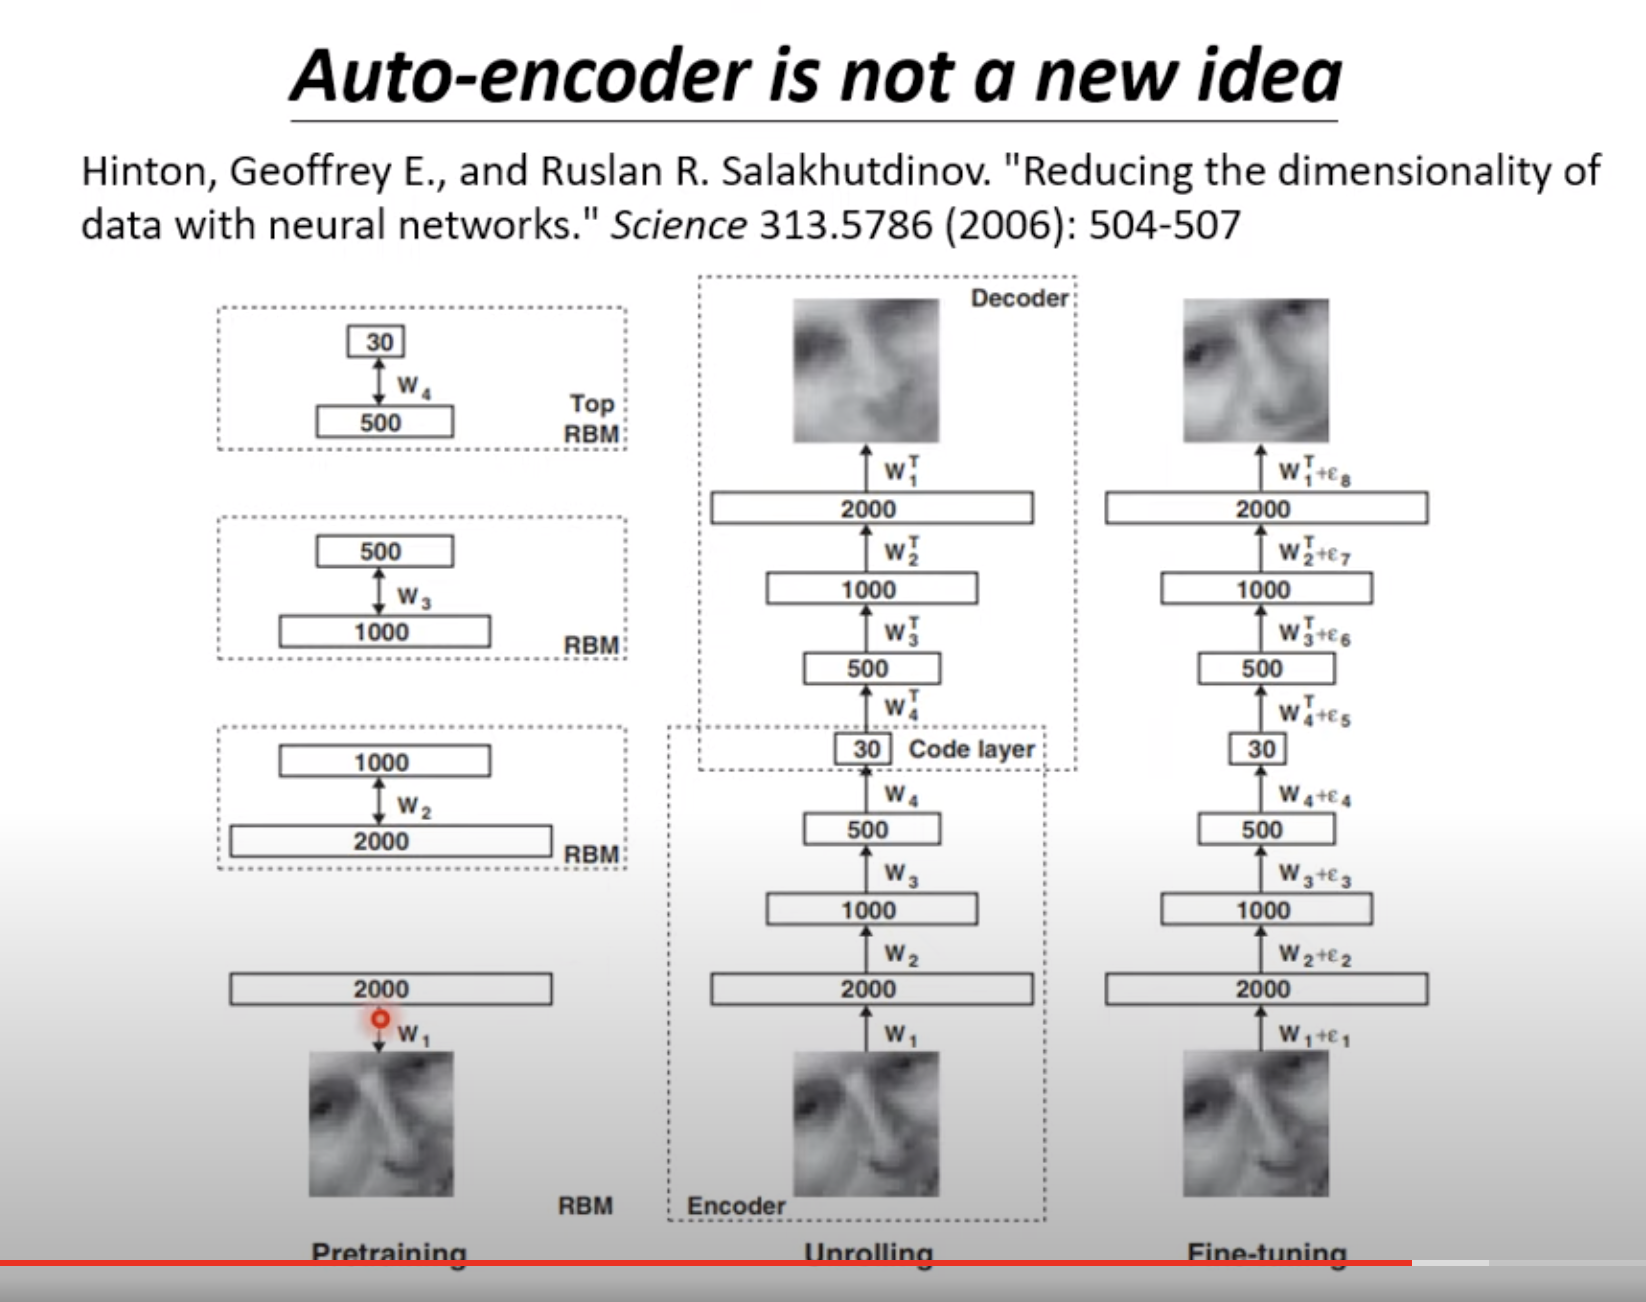

In [ ]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

In [ ]:
train = pd.read_csv('ml-100k/u1.base',sep='\t',header=None
                    ,names=['userid','movieid','rating','timestamp'])
train = train.drop(columns='timestamp')
train.head()
                    

,userid,movieid,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3


In [ ]:
test = pd.read_csv('ml-100k/u1.test',sep='\t',header=None
                    ,names=['userid','movieid','rating','timestamp'])
test = test.drop(columns='timestamp')
test.head()

,userid,movieid,rating
0,1,6,5
1,1,10,3
2,1,12,5
3,1,14,5
4,1,17,3


In [ ]:
unique_users = train['userid'].append(test['userid']).nunique()
unique_movies = train['movieid'].append(test['movieid']).nunique()
print('number of unique users present in the train-test data:', unique_users)
print('number of unique movies present in the train-test data:', unique_movies)

number of unique users present in the train-test data: 943
number of unique movies present in the train-test data: 1682


In [ ]:
def users_and_movies_array(df):  
    
    users_and_movies = np.zeros((943,1682)) #shape=[n_users,n_movies]
    
    #for each userid and movieid, assign rating to the corresponding position of users_and_movies matrix 
    for user_id,movie_id,rating in zip(df['userid'],df['movieid'],df['rating']):
        users_and_movies[user_id-1,movie_id-1] = rating
        
    return users_and_movies

In [ ]:
#run the data-transforming function
train_array = users_and_movies_array(train)
test_array = users_and_movies_array(test)

#get tensors
train_tensor = torch.FloatTensor(train_array)
test_tensor = torch.tensor(test_array)

Autoencoder model

In [ ]:
class AE(nn.Module):
  def __init__(self,):
    super(AE,self).__init__()
    self.l1 = nn.Linear(1682,50)
    self.l2 = nn.Linear(50,20)
    self.l3 = nn.Linear(20,10)
    self.l4 = nn.Linear(10,20)
    self.l5 = nn.Linear(20,50)
    self.out_layer = nn.Linear(50,1682)
    self.act = nn.Sigmoid()

  def forward(self,x):
    x = self.act(self.l1(x))
    x = self.act(self.l2(x))
    x = self.act(self.l3(x))
    x = self.act(self.l4(x))
    x = self.act(self.l5(x))
    x = self.out_layer(x)
    return x

In [ ]:
#實例化模型並初始化一些參數。
lr = 1e-3
n_epochs = 251

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AE()
loss_fn = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(),lr=lr,weight_decay=0.3)
print(model)

AE(
  (l1): Linear(in_features=1682, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=20, bias=True)
  (l3): Linear(in_features=20, out_features=10, bias=True)
  (l4): Linear(in_features=10, out_features=20, bias=True)
  (l5): Linear(in_features=20, out_features=50, bias=True)
  (out_layer): Linear(in_features=50, out_features=1682, bias=True)
  (act): Sigmoid()
)


In [ ]:
# 訓練模型以及畫出loss
model.train()
model.to(device)
n_users = 943
n_movies = 1682
loss_history = []

for epoch in range(1,n_epochs):
    
    epoch_loss = 0
    n_nonzero = 0 #users who've rated at least one movie
    
    for i in range (n_users): #run a training iter for each user
        
        x = Variable(train_tensor[i]).unsqueeze(0)
        y = x.clone()
        if y.sum() > 0:
            preds = model(x)
            y.require_grad = False
            preds [y==0] = 0
            loss = loss_fn(preds,y)
            loss.backward()
            optimizer.step()

            mean_corrector = n_movies/((y>0).sum()+1e-10)  
            epoch_loss += np.sqrt(loss.data*mean_corrector)
            n_nonzero += 1
    corrected_epoch_loss = epoch_loss/n_nonzero

    
    loss_history.append(corrected_epoch_loss)
    if (epoch==1) | (epoch%50==0):
        print('epoch:',epoch,'loss:',corrected_epoch_loss)

epoch: 1 loss: tensor(1.4053)
epoch: 50 loss: tensor(1.0117)
epoch: 100 loss: tensor(1.0071)
epoch: 150 loss: tensor(0.9983)
epoch: 200 loss: tensor(0.9316)
epoch: 250 loss: tensor(0.9080)


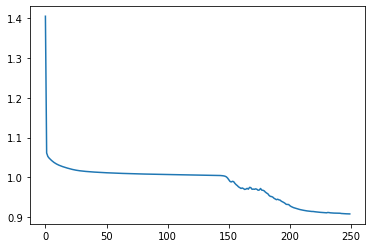

In [ ]:
plt.plot(loss_history)

Test Model

In [ ]:
test_loss = 0
n_nonzero = 0 #users who've rated at least one movie

for i in range (n_users):
    
    x = Variable(train_tensor[i]).unsqueeze(0)
    y = Variable(test_tensor[i]).unsqueeze(0)
    y.require_grad = False

    if y.sum()>0:
        
        preds = model(x)
        preds [y==0] = 0
        loss = loss_fn(preds,y)
        mean_corrector = n_movies/((y>0).sum()+1e-10)
        test_loss += np.sqrt(loss.data*mean_corrector)
        n_nonzero += 1
        
    corrected_test_loss = test_loss/n_nonzero
    
print('test loss:',corrected_test_loss)

test loss: tensor(0.9533, dtype=torch.float64)


產生一些預測並與事實並列，以對照結果

In [ ]:
random_user_id = 100
preds = model(train_tensor[random_user_id+1])


juxtapose = pd.DataFrame()
juxtapose['title'] = movie_dataset['title']
juxtapose['ground_truth_rating'] = test_tensor[random_user_id+1]
juxtapose['predicted_rating'] = preds.detach().numpy()

if (test_tensor[random_user_id+1]).sum() == 0: print('user has no ratings in the test set')
else: 
    print(random_user_id)
    display(juxtapose[juxtapose['ground_truth_rating']>0].head())

100


,title,ground_truth_rating,predicted_rating
4,Copycat (1995),3.0,2.119640
46,Ed Wood (1994),2.0,2.766253
49,Star Wars (1977),4.0,3.698312
61,Stargate (1994),3.0,2.258358
65,While You Were Sleeping (1995),3.0,2.609036


提出推薦項目
有了訓練好的目標，因此可以將用戶的評分矢量輸入到AE模型中，預測用戶為觀看的電影評分，將其從高到低排序。即得到推薦名單

In [ ]:
#make recommendations

random_user_id = 100

preds = model(train_tensor[random_user_id+1])

recommendations = pd.DataFrame()
recommendations['title'] = movie_dataset['title']
recommendations['predicted_rating'] = preds.detach().numpy()
recommendations[train_array[random_user_id+1]==0]\
                .sort_values(by='predicted_rating',ascending=False)\
                .reset_index(drop=True)[:10]

,title,predicted_rating
0,"Close Shave, A (1995)",4.559811
1,"Wrong Trousers, The (1993)",4.087372
2,Henry V (1989),3.964502
3,12 Angry Men (1957),3.943612
4,"Usual Suspects, The (1995)",3.860066
5,"Shawshank Redemption, The (1994)",3.769469
6,One Flew Over the Cuckoo's Nest (1975),3.752096
7,Sunset Blvd. (1950),3.738922
8,Blade Runner (1982),3.725825
9,Star Wars (1977),3.698312
